# Python Setup

In [1]:
from sklearn import mixture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import os
from scipy.spatial import distance as scipy_distance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from numpy.linalg import norm
from tqdm.auto import tqdm
import geopandas as gpd
import geoplot
import itertools
from numpy.polynomial.polynomial import polyfit
from matplotlib import patches

random_state = 123
from sklearn.cluster import KMeans

In [2]:
os.chdir('..')
from src.py.utils.plotting_utils import spider_plot, plot_gmm_bic, plot_gmm_clusters
from src.py.utils.clustering_utils import print_content_summary, k_means
os.chdir('notebooks/')

In [3]:
states = gpd.read_file(geoplot.datasets.get_path('contiguous_usa'))
del states['adm1_code']

In [4]:
n_pca_components = 80
datapath = '../data/topical_tweets/chinese_virus'

In [5]:
def get_topic_frequency(topic):
    with open('../data/topical_tweets/topical_subsetting_%s.log' % topic, 'r') as file:
        data = file.read()
        
    data = [x.strip() for x in data.split('Subsetting data for') if x.strip()!='' ]
    
    df = pd.DataFrame({
        'day': [x[:8] for x in data],
        'method': [x[12:x.find('\n')].strip().lower().replace(' ', '_') for x in data],
        'nb_tweets': [float(x[x.find(':')+2:-15]) for x in data]
    })
    df = df.pivot(index='day', columns='method', values='nb_tweets').reset_index()
    df['date'] = pd.to_datetime(df['day'].astype(str), format='%Y%m%d')
    
    return df

freq = get_topic_frequency('chinese_virus')

In [6]:
def pca_analysis(X, n_components=2, random_state=random_state):
    
    X_std = StandardScaler().fit_transform(X)
    
    pca_model = PCA(n_components=n_components, random_state=random_state)
    coords = pca_model.fit_transform(X_std)
    explained_variance = pca_model.explained_variance_ratio_
        
    return {'pca_model': pca_model, 'coords':coords, 'explained_variance':explained_variance}

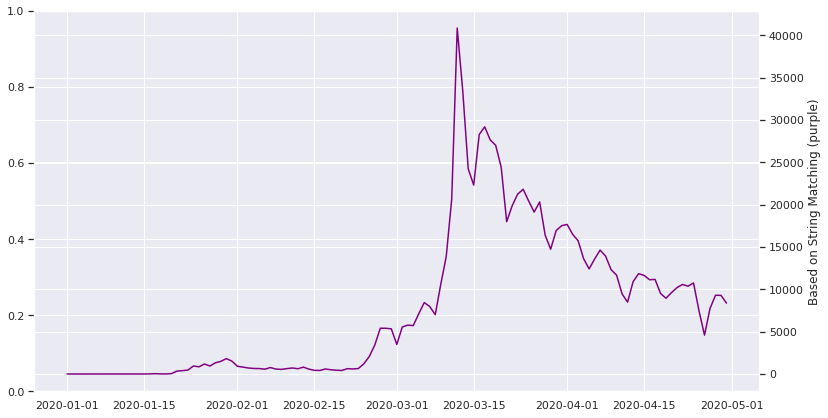

In [7]:
df = get_topic_frequency('covid')

plt.subplots(figsize=(13,7))

# ax1 = sns.lineplot(x='date', y='topic_modeling', data=df, label='Topic Modeling', color='green')
# ax1.set_ylabel('Based on Topic Modeling (green)')
# ax1.get_legend().remove()

ax2 = plt.twinx()
ax2 = sns.lineplot(x='date', y='string_matching', data=df, label='String Matching', color='purple')
ax2.set_ylabel('Based on String Matching (purple)')
ax2.get_legend().remove()

# ax1.set_title('Number of Tweets on COVID-19', size='xx-large')

plt.savefig('../output/covid/time_series.jpg', bbox_inches='tight')

plt.show()

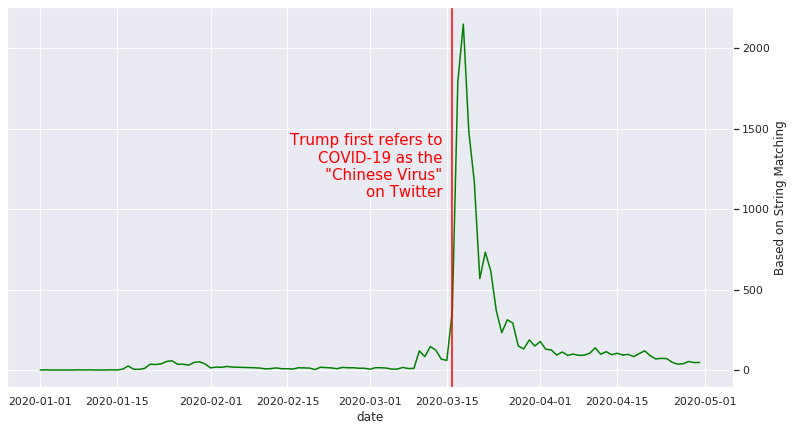

In [8]:
plt.subplots(figsize=(13,7))

ax = sns.lineplot(x='date', y='string_matching', data=freq, label='String Matching', color='green')
ax.set_ylabel('Based on String Matching')
ax.get_legend().remove()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

ax.axvline('2020-03-16', color='red')
ax.text(
    .6, .50, 'Trump first refers to\nCOVID-19 as the\n\"Chinese Virus\"\non Twitter', 
    transform=ax.transAxes, horizontalalignment='right', color='red', size=15
)

# ax.set_title('Number of Tweets using\nthe term \"Chinese Virus\"', size='xx-large')

plt.savefig('../output/chinese_virus/time_series.jpg', bbox_inches='tight')

plt.show()

In [19]:
freq = df.groupby('date')['tweet_id'].count().reset_index()

In [9]:
emb = np.empty((0,768))
df = pd.DataFrame()
for date in [20200101, 20200102, 20200103, 20200104, 20200105, 20200106, 20200107, 20200108, 20200109, 20200110, 20200111, 20200112, 20200113, 20200114, 20200115, 20200116, 20200117, 20200118, 20200119, 20200120, 20200121, 20200122, 20200123, 20200124, 20200125, 20200126, 20200127, 20200128, 20200129, 20200130, 20200131, 20200201, 20200202, 20200203, 20200204, 20200205, 20200206, 20200207, 20200208, 20200209, 20200210, 20200211, 20200212, 20200213, 20200214, 20200215, 20200216, 20200217, 20200218, 20200219, 20200220, 20200221, 20200222, 20200223, 20200224, 20200225, 20200226, 20200227, 20200228, 20200229, 20200301, 20200302, 20200303, 20200304, 20200305, 20200306, 20200307, 20200308, 20200309, 20200310, 20200311, 20200312, 20200313, 20200314, 20200315, 20200316, 20200317, 20200318, 20200319, 20200320, 20200321, 20200322, 20200323, 20200324, 20200325, 20200326, 20200327, 20200328, 20200329, 20200330, 20200331, 20200401, 20200402, 20200403, 20200404, 20200405, 20200406, 20200407, 20200408, 20200409, 20200410, 20200411, 20200412, 20200413, 20200414, 20200415, 20200416, 20200417, 20200418, 20200419, 20200420, 20200421, 20200422, 20200423, 20200424, 20200425, 20200426, 20200427, 20200428, 20200429, 20200430]:
    
    print("============================================")
    print('Processing data from date: %s' % date)
    
    temp_df = pd.read_csv(os.path.join(datapath, str(date)+'_from_string_match.tsv'), lineterminator='\n', sep='\t')
    temp_df['date'] = date
    
    temp_emb = np.load(os.path.join(datapath, str(date)+'_from_string_match_embeddings.npy'))
    
    print('number of tweets: %s' % temp_emb.shape[0])
    
    if temp_emb.shape[0]>0:

        emb = np.concatenate([emb, temp_emb])
        df = pd.concat([df, temp_df], sort=False).reset_index(drop=True)

print("\nFinal shape:", df.shape, emb.shape)

Processing data from date: 20200101
number of tweets: 0
Processing data from date: 20200102
number of tweets: 1
Processing data from date: 20200103
number of tweets: 0
Processing data from date: 20200104
number of tweets: 0
Processing data from date: 20200105
number of tweets: 0
Processing data from date: 20200106
number of tweets: 0
Processing data from date: 20200107
number of tweets: 0
Processing data from date: 20200108
number of tweets: 1
Processing data from date: 20200109
number of tweets: 0
Processing data from date: 20200110
number of tweets: 1
Processing data from date: 20200111
number of tweets: 0
Processing data from date: 20200112
number of tweets: 0
Processing data from date: 20200113
number of tweets: 0
Processing data from date: 20200114
number of tweets: 0
Processing data from date: 20200115
number of tweets: 0
Processing data from date: 20200116
number of tweets: 5
Processing data from date: 20200117
number of tweets: 25
Processing data from date: 20200118
number of t

Processing data from date: 20200326
number of tweets: 288
Processing data from date: 20200327
number of tweets: 269
Processing data from date: 20200328
number of tweets: 138
Processing data from date: 20200329
number of tweets: 121
Processing data from date: 20200330
number of tweets: 167
Processing data from date: 20200331
number of tweets: 121
Processing data from date: 20200401
number of tweets: 153
Processing data from date: 20200402
number of tweets: 115
Processing data from date: 20200403
number of tweets: 106
Processing data from date: 20200404
number of tweets: 96
Processing data from date: 20200405
number of tweets: 105
Processing data from date: 20200406
number of tweets: 77
Processing data from date: 20200407
number of tweets: 86
Processing data from date: 20200408
number of tweets: 83
Processing data from date: 20200409
number of tweets: 85
Processing data from date: 20200410
number of tweets: 94
Processing data from date: 20200411
number of tweets: 138
Processing data from

In [10]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-large-nli-stsb-mean-tokens')
corpus = df['tweet_text_clean'].fillna('').values
emb = model.encode(corpus, show_progress_bar=True)

In [13]:
np.save('chinese_virus_emb.npy', emb)

In [12]:
emb.shape

(14984, 1024)

In [13]:
df.to_csv('chinese_virus_df.tsv', sep='\t', index=False)

In [14]:
df

,tweet_id,lang,tweet_text,tweet_text_clean,tweet_text_stemmed,tweet_time,sender_id,reply_to_tweet_id,followers,lat,lon,country,admin1,admin2,place_name,date
0,id_1212833110548549632,en,@aetiology I appreciate you keeping us updated...,@aetiology i appreciate you keeping us updated...,@aetiology appreci keep us updat chines virus ...,1.577997e+09,1.442619e+07,NaN,280.0,40.023983,-105.242683,US,Colorado,Boulder,Boulder,20200102
1,id_1215022491489333249,en,"@WSJ Oh goody, we can plan on another Chinese...","@wsj oh goody, we can plan on another chinese ...",@wsj oh goodi plan anoth chines virus let loos...,1.578519e+09,2.360627e+08,NaN,193.0,40.448608,-122.296318,US,California,Shasta,Anderson,20200108
2,id_1215627945244532736,en,Mystery Chinese virus: How worried should we b...,mystery chinese virus: how worried should we be?,mysteri chines virus worri,1.578663e+09,8.587621e+08,NaN,11832.0,41.919117,-72.543175,US,Connecticut,Hartford,Broad Brook,20200110
3,id_1217805880672034816,en,"So, how did they recognize a Chinese Virus in ...","so, how did they recognize a chinese virus in ...",recogn chines virus japan speak languag,1.579183e+09,9.259851e+08,NaN,3031.0,31.168894,-100.076889,US,Texas,Concho,Texas,20200116
4,id_1217947447000911873,en,WHO issues warning after 'mysterious' Chinese ...,who issues warning after 'mysterious' chinese ...,issu warn mysteri chines coronavirus spread japan,1.579216e+09,1.044065e+18,NaN,1508.0,36.232914,-115.223122,US,Nevada,Clark,Las Vegas,20200116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14979,id_1255975536741896192,en,Hey #Dumdum it's not China's fault that it sp...,hey #dumdum it's not china's fault that it spr...,hey #dumdum china fault spread listen anyon th...,1.588283e+09,2.338433e+09,NaN,3828.0,35.923874,-78.926987,US,North Carolina,Durham,Shell,20200430
14980,id_1255977017390125056,en,So much time and energy wasted on spewing bull...,so much time and energy wasted on spewing bull...,much time energi wast spew bullshit chose ride...,1.588283e+09,1.041011e+09,NaN,29008.0,32.819859,-96.761757,US,Texas,Dallas,Dallas,20200430
14981,id_1255985204726042624,en,How does he get off thinking about RETALIATION...,how does he get off thinking about retaliation...,get think retali told covid threat novemb us i...,1.588285e+09,8.735473e+17,NaN,15586.0,42.084568,-71.026772,US,Massachusetts,Plymouth,Brockton,20200430
14982,id_1255995630524280832,en,U.S. officials crafting retaliation against Ch...,u.s. officials crafting retaliation against ch...,offici craft retali china coronavirus,1.588288e+09,3.679371e+08,NaN,128.0,32.655678,-97.011169,US,Texas,Dallas,Lakeland Heights,20200430


In [51]:
pca_results_dict = pca_analysis(emb, n_components=100)
pca_coords = pca_results_dict['coords']

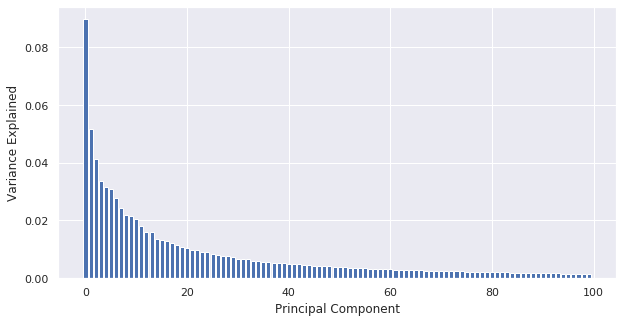

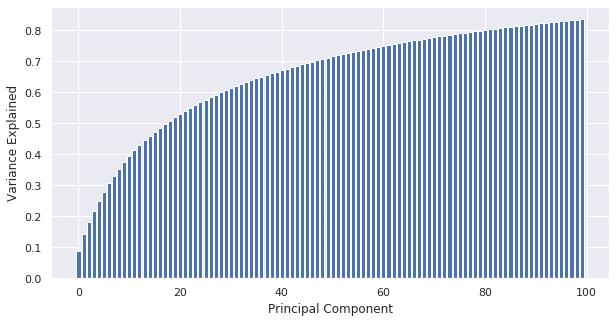

In [52]:
plt.subplots(figsize=(10,5))
plt.bar(range(100), pca_results_dict['explained_variance'])
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

plt.subplots(figsize=(10,5))
plt.bar(range(100), np.cumsum(pca_results_dict['explained_variance']))
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [53]:
# Restrict to n_components:
pca_coords = pca_coords[:,:n_pca_components]

# Testing for Values of `n_clusters`

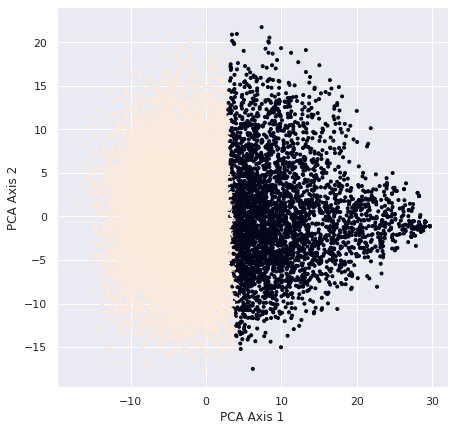

In [62]:
model, labels, centers, inertia = k_means(pca_coords, n_clusters=2)

plt.subplots(figsize=(7,7))
plt.scatter(pca_coords[:,0], pca_coords[:,1], marker='.', c=labels)
plt.xlabel('PCA Axis 1')
plt.ylabel('PCA Axis 2')
plt.savefig('../output/chinese_virus/kmeans_2.jpg', bbox_inches='tight')
plt.show()

In [59]:
%%capture cap --no-stderr
print_content_summary(centers=centers, coordinates=pca_coords, labels=labels, tweets=df)

In [60]:
with open('../output/chinese_virus/kmeans_2.txt', 'w') as f:
    f.write(cap.stdout)
print(cap.stdout)


Cluster 0 (3843 tweets) is approximated by:
-  what’s the chinese virus (Score: 0.933)
-  who is calling it chinese virus.... (Score: 0.929)
-  it’s a chinese virus, right? (Score: 0.924)
-  call it what it is the chinese virus (Score: 0.913)
-  it’s the chinese virus. (Score: 0.911)

Cluster 1 (10305 tweets) is approximated by:
-  @realdonaldtrump is facing some of the toughest times americans have had to face, gets criticized each day, but yet he stands proud to be our president. let’s all put the political bs aside and let him do his job. thank you 🇺🇸 💪 🙏 #potus #maga #chinesevirus #covid19 #trump2020… (Score: 0.699)
-  god bless the state of #texasprolife! @thedemocrats want @realdonaldtrump to keep the us closed due to #chinesecoronavirus so the economy tanks and he loses the 2020 election. yet they don't want it closed for this? (Score: 0.653)
-  #donaldjtrump needs to get rid of #deepstate lover #drfauci. trump supporters not happy with him and his negativity. find someone more

0. Chinese vieurs is offensive
1. It's a chinese virus

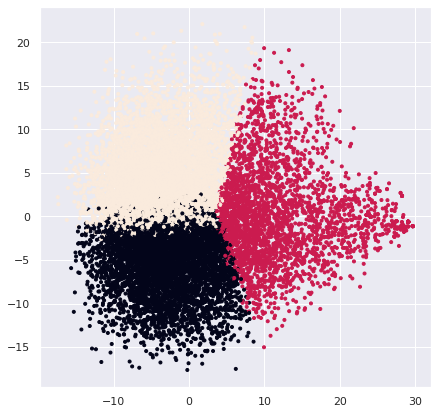

In [65]:
model, labels, centers, inertia = k_means(pca_coords, n_clusters=3)

plt.subplots(figsize=(7,7))
plt.scatter(pca_coords[:,0], pca_coords[:,1], marker='.', c=labels)
plt.show()

In [66]:
%%capture cap --no-stderr
print_content_summary(centers=centers, coordinates=pca_coords, labels=labels, tweets=df)

In [67]:
with open('../output/chinese_virus/kmeans_3.txt', 'w') as f:
    f.write(cap.stdout)
print(cap.stdout)


Cluster 0 (5473 tweets) is approximated by:
-  going live with the covid19 : the return of kungflu! stream . and join us ! @manvsmonkey @kazaragi072 #drunkquest @sgh_rts @zooretweets @owlrtz @retweetmixer @mixerretweet @quickest_rts @rsg_retweet @dlive_retweet (Score: 0.734)
-  i’m thinking everyone got the #covid19 🦠 in their system 😳 someone launched a satellite in orbit and spread it 🛸 activated by 5g tech 🤷🏽‍♂️🤔🤦🏽‍♂️😳🧻🧟‍♀️🧟‍♂️😷💩🤣 #kungflu #biologicalwarfare #pinoy #stayhome #shelterinplace #socialdistancing #sosyaldistancing (Score: 0.725)
-  this is the truth to the @housedemocrats @senatedems hold up to the bill to help this country! they want to use this #covidー19 crisis to flip the country to socialism! #chinavirus #wuhanvirus @seanhannity @marklevinshow @bosnerdley @realjameswoods @arifleischer @saracarterdc… (Score: 0.704)
-  i’m watching @tuckercarlson folks i have great new: @realdonaldtrump is always right we will go back to work for easter❤️🇺🇸🙏 #believe #easter #reopenam

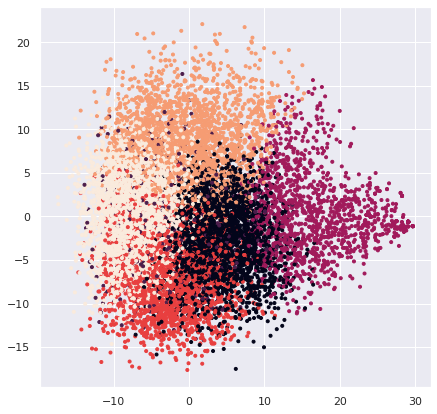

In [68]:
model, labels, centers, inertia = k_means(pca_coords, n_clusters=6)

plt.subplots(figsize=(7,7))
plt.scatter(pca_coords[:,0], pca_coords[:,1], marker='.', c=labels)
plt.show()

In [69]:
%%capture cap --no-stderr
print_content_summary(centers=centers, coordinates=pca_coords, labels=labels, tweets=df)

In [70]:
with open('../output/chinese_virus/kmeans_6.txt', 'w') as f:
    f.write(cap.stdout)
print(cap.stdout)


Cluster 0 (2878 tweets) is approximated by:
-  the china virus started in china...that's a fact not racism (Score: 0.736)
-  it’s not racist.. it is a chinese virus. #wuhancoronavirus (Score: 0.719)
-  chinese virus gives people it's origin, it's not a prejudice statement. (Score: 0.711)
-  oh good, not a chinese virus twit, thanks. (Score: 0.707)
-  it’s not the chinese virus you little (Score: 0.700)

Cluster 1 (735 tweets) is approximated by:
-  kung flu fighting. (Score: 0.865)
-  kung flu fighting. (Score: 0.865)
-  i got kung flu! (Score: 0.857)
-  it's the kung flu (Score: 0.850)
-  kung flu fighting (Score: 0.849)

Cluster 2 (1476 tweets) is approximated by:
-  what’s the chinese virus (Score: 0.954)
-  who is calling it chinese virus.... (Score: 0.945)
-  "chinese virus"😭😭😭 (Score: 0.932)
-  "chinese virus" 🤦‍♂️🤦‍♂️🤦‍♂️ (Score: 0.932)
-  "the chinese virus" (Score: 0.931)

Cluster 3 (2790 tweets) is approximated by:
-  .@housedemocrats @thedemocrats @speakerpelosi @amy_siskin

0. Information/conspiracies? about chinese virus effects
1. Information/news about chinese virus controversy
2. We should not call it the chinese virus
3. It's a chinese virus
4. Chinese virus is racist
5. Chinese virus

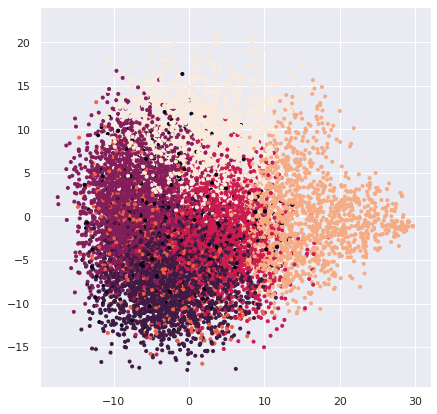


Cluster 0 (704 tweets) is approximated by:
-  kung flu fighting. (Score: 0.869)
-  kung flu fighting. (Score: 0.869)
-  i got kung flu! (Score: 0.859)
-  kung flu fighting (Score: 0.853)
-  it's the kung flu (Score: 0.852)

Cluster 1 (2597 tweets) is approximated by:
-  #easterhumour #whoareyourfour weeleverage ivgi.idan #dirtymikeandtheboys #lockdown2020 brought to you by #kingcobrabeer at the #theblackcave #shootthebeer #coronavirusmemes #wuhanvirus #chinavirus #hongkongdragons… (Score: 0.770)
-  let's put things into perspective #coronavirus #covidー19 #chinesewuhanvirus #chinesevirus #plandemic #plandemic2020 #deepstate #who #cdc #intellectuallydishonest #wethepeople #constitutionovercoronavirus #hydroxychloroquine #bigpharma #trump2020 #trumpderangementsyndrome #kag… (Score: 0.754)
-  the new way to go out! lol #covid19 #pandemic #kungflu #kungflufighting #coronavirus #covid #trump #maga #thegreatawakening #quarantine #chinesevirus #makeamericagreatagain #socialdistancing #keepame

In [71]:
model, labels, centers, inertia = k_means(pca_coords, n_clusters=7)

plt.subplots(figsize=(7,7))
plt.scatter(pca_coords[:,0], pca_coords[:,1], marker='.', c=labels)
plt.show()

print_content_summary(centers=centers, coordinates=pca_coords, labels=labels, tweets=df)

In [99]:
label_dict = {
    0: 'It\'s not a Chinese virus',
    1: 'It is a Chinese virus',
    2: 'We should not call it ``Chinese virus\'\'',
    3: 'Casual use of ``Chinese virus\'\'',
    4: 'Conspiracies on ``Chinese virus\'\'',
    5: '``Chinese virus\'\' is racist',
    6: 'Information on ``Chinese virus\'\' controversy'
}

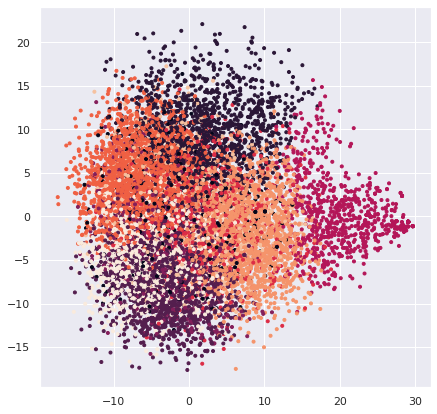


Cluster 0 (635 tweets) is approximated by:
-  kung flu fighting. (Score: 0.875)
-  kung flu fighting. (Score: 0.875)
-  i got kung flu! (Score: 0.861)
-  kung flu fighting (Score: 0.859)
-  the fucking kung flu* (Score: 0.858)

Cluster 1 (1542 tweets) is approximated by:
-  calling this “the chinese virus” is very racist and disgusting (Score: 0.880)
-  "chinese virus " you're dumb and racist as fuck! (Score: 0.873)
-  “chinese virus” is so fucking racist (Score: 0.870)
-  chinese virus? this man is a fucking idiot. so blatantly racist. (Score: 0.851)
-  chinese virus? oh my god, that’s so racist... (Score: 0.847)

Cluster 2 (1866 tweets) is approximated by:
-  #easterhumour #whoareyourfour weeleverage ivgi.idan #dirtymikeandtheboys #lockdown2020 brought to you by #kingcobrabeer at the #theblackcave #shootthebeer #coronavirusmemes #wuhanvirus #chinavirus #hongkongdragons… (Score: 0.782)
-  let's put things into perspective #coronavirus #covidー19 #chinesewuhanvirus #chinesevirus #pland

In [72]:
model, labels, centers, inertia = k_means(pca_coords, n_clusters=10)

plt.subplots(figsize=(7,7))
plt.scatter(pca_coords[:,0], pca_coords[:,1], marker='.', c=labels)
plt.show()

print_content_summary(centers=centers, coordinates=pca_coords, labels=labels, tweets=df)

# With set number of clusters:

In [74]:
n_clusters=6
model, labels, centers, inertia = k_means(pca_coords, n_clusters=n_clusters)

In [75]:
label_dict = {
    0: 'Conspiracies on ``Chinese virus\'\'',
    1: 'Info on ``Chinese virus\'\' controversy',
    2: 'We shouldn\'t call it ``Chinese virus\'\'',
    3: 'It is a ``Chinese virus\'\'',
    4: '``Chinese virus\'\' is racist',
    5: 'Simple use of ``Chinese virus\'\''
}
# label_dict = {
#     0: 'It\'s not a Chinese virus',
#     1: 'It is a Chinese virus',
#     2: 'We should not call it ``Chinese virus\'\'',
#     3: 'Casual use of ``Chinese virus\'\'',
#     4: 'Conspiracies on ``Chinese virus\'\'',
#     5: '``Chinese virus\'\' is racist',
#     6: 'Information on ``Chinese virus\'\' controversy'
# }

with open('../output/chinese_virus/kmeans_cluster_interpretation.tex', 'w') as f:
    pd.DataFrame({
        'Topic':list(label_dict.keys()),
        'Interpretation': list(label_dict.values()),
        '# Tweets': [list(labels).count(i) for i in range(n_clusters)]
    }).to_latex(buf=f, index=False, column_format = 'clr')

## Cluster Analysis

How dense are the clusters? Which ones are close to each other? Etc.

In [76]:
df['cluster'] = labels
df['cluster_int'] = [label_dict[i] for i in df['cluster'].values]

In [77]:
df['cluster_int'].value_counts()

Simple use of ``Chinese virus''           3583
Conspiracies on ``Chinese virus''         2878
It is a ``Chinese virus''                 2790
``Chinese virus'' is racist               2686
We shouldn't call it ``Chinese virus''    1476
Info on ``Chinese virus'' controversy      735
Name: cluster_int, dtype: int64

In [78]:
center_distances = np.ones((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        if i<j:
            center_distances[i,j] = np.nan
        else:
            center_distances[i,j] = np.round(scipy_distance.cdist([centers[i]],[centers[j]],metric='cosine')[0][0],2)
pd.DataFrame(
    center_distances, 
    index=[label_dict[i] for i in range(n_clusters)], 
    columns=[label_dict[i] for i in range(n_clusters)]
)

,Conspiracies on ``Chinese virus'',Info on ``Chinese virus'' controversy,We shouldn't call it ``Chinese virus'',It is a ``Chinese virus'',``Chinese virus'' is racist,Simple use of ``Chinese virus''
Conspiracies on ``Chinese virus'',0.00,NaN,NaN,NaN,NaN,NaN
Info on ``Chinese virus'' controversy,1.23,0.00,NaN,NaN,NaN,NaN
We shouldn't call it ``Chinese virus'',0.55,1.13,0.00,NaN,NaN,NaN
It is a ``Chinese virus'',1.30,1.06,1.33,0.00,NaN,NaN
``Chinese virus'' is racist,1.48,1.09,1.06,1.41,0.00,NaN
Simple use of ``Chinese virus'',1.32,1.00,1.81,1.01,1.06,0.0


## Over time trends

In [79]:
def moving_average(a, n=3) :
    ret = np.cumsum(a.values, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret = ret[n-1:]/n
    a = np.empty((n-1,))
    a[:] = np.nan
    ret = np.concatenate([a, ret])
    return ret

In [89]:
by_day = pd.crosstab(df['date'], df['cluster_int']).reset_index()
by_day['total_tweets'] = by_day[list(set(df['cluster_int']))].sum(axis=1)
by_day['date'] = pd.to_datetime(by_day['date'], format='%Y%m%d')
by_day = by_day[(by_day['date']>='2020-03-12')]

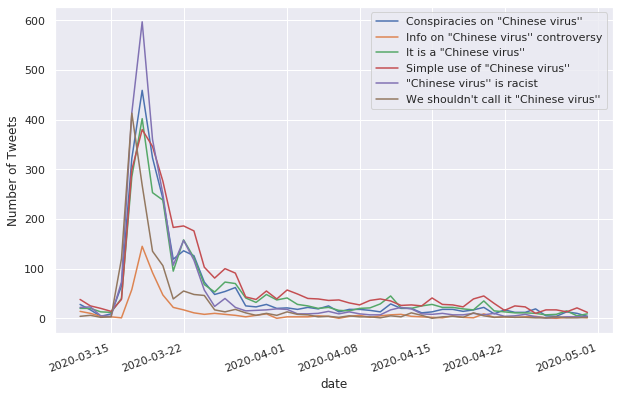

In [90]:
plt.subplots(figsize=(10,6))
for var in list(set(df['cluster_int'])):
    sns.lineplot(by_day['date'], by_day[var], label=var.replace('``', '"'))
plt.ylabel('Number of Tweets')
plt.xticks(rotation=20, horizontalalignment='right')
plt.show()

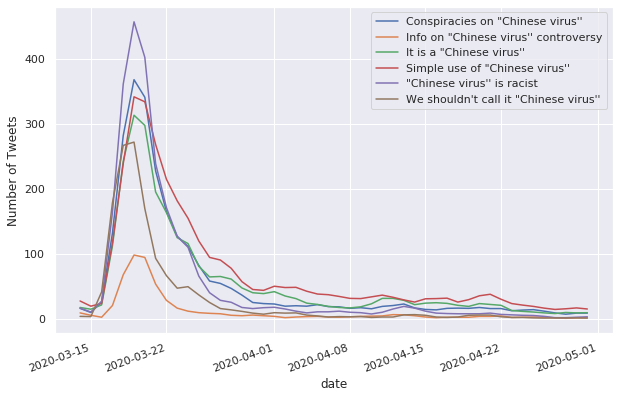

In [91]:
plt.subplots(figsize=(10,6))
for var in list(set(df['cluster_int'])):
    sns.lineplot(by_day['date'], moving_average(by_day[var]), label=var.replace('``', '"'))
plt.ylabel('Number of Tweets')
plt.xticks(rotation=20, horizontalalignment='right')
plt.savefig('../output/chinese_virus/topic_time_series.jpg', bbox_inches='tight')
plt.show()

In [87]:
# plt.subplots(figsize=(10,6))
# for var in list(set(df['cluster_int'])):
#     sns.lineplot(by_day['date'], moving_average(np.log(by_day[var])), label=var.replace('``', '"'))
# plt.ylabel('Number of Tweets')
# plt.xticks(rotation=20, horizontalalignment='right')
# plt.savefig('../output/chinese_virus/topic_time_series_log.jpg', bbox_inches='tight')
# plt.show()

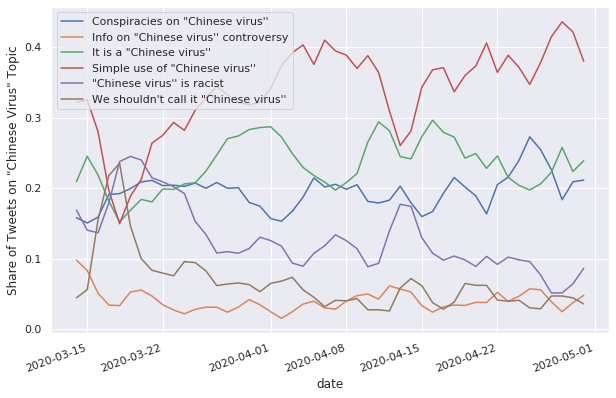

In [92]:
for var in list(set(df['cluster_int'])):
    by_day[var+"_share"] = by_day[var]/by_day['total_tweets']

plt.subplots(figsize=(10,6))
for var in list(set(df['cluster_int'])):
    sns.lineplot(by_day['date'], moving_average(by_day[var+"_share"]), label=var.replace('``', '"'))
plt.ylabel('Share of Tweets on "Chinese Virus" Topic')
plt.xticks(rotation=20, horizontalalignment='right')
plt.savefig('../output/chinese_virus/topic_time_series_share.jpg', bbox_inches='tight')
plt.show()

## Geography Analysis

In [93]:
by_state = pd.crosstab(df['admin1'], df['cluster_int']).reset_index()
by_state['total_tweets'] = by_state[list(set(df['cluster_int']))].sum(axis=1)
by_state = pd.merge(by_state, states.rename(columns={'state':'admin1'}), how='left', on='admin1')
for var in list(set(df['cluster_int'])):
    by_state[var] = by_state[var]/by_state['total_tweets']
by_state = by_state[by_state['population'].notnull()].reset_index(drop=True)

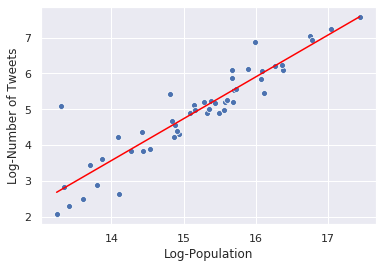

Outliers:

              State Name  Relative Position
7   District of Columbia               2.33
17                 Maine              -1.05
28            New Jersey               0.98
26                Nevada               0.91
39          South Dakota              -0.63
48               Wyoming              -0.60
20              Michigan              -0.59
32          North Dakota              -0.59
40             Tennessee               0.58
27         New Hampshire               0.54


In [94]:
x = np.log(by_state['population'])
y = np.log(by_state['total_tweets'])

b, m = polyfit(x, y, 1)

sns.scatterplot(x, y)
sns.lineplot(x, b + m*x, color='red')
plt.ylabel('Log-Number of Tweets')
plt.xlabel('Log-Population')
plt.savefig('../output/chinese_virus/reg_outliers.jpg', bbox_inches='tight')
plt.show()

# Find furthest points to the regression line:
print("Outliers:\n")
by_state['distance'] = y - (b+m*x)
by_state['abs_distance'] = np.abs(by_state['distance'])
outliers = by_state.sort_values('abs_distance', ascending=False)[['admin1', 'distance']].head(10)
outliers.rename(columns={'admin1':'State Name', 'distance':'Relative Position'}, inplace=True)
print(outliers.round(decimals=2))
with open('../output/chinese_virus/reg_outliers.tex', 'w') as f:
    outliers.round(decimals=2).to_latex(buf=f, index=False)
del by_state['distance'], by_state['abs_distance']

- DC is talking about it a lot, but that is usual (see `preliminary_statistics`)
- New Jersey is more surprising

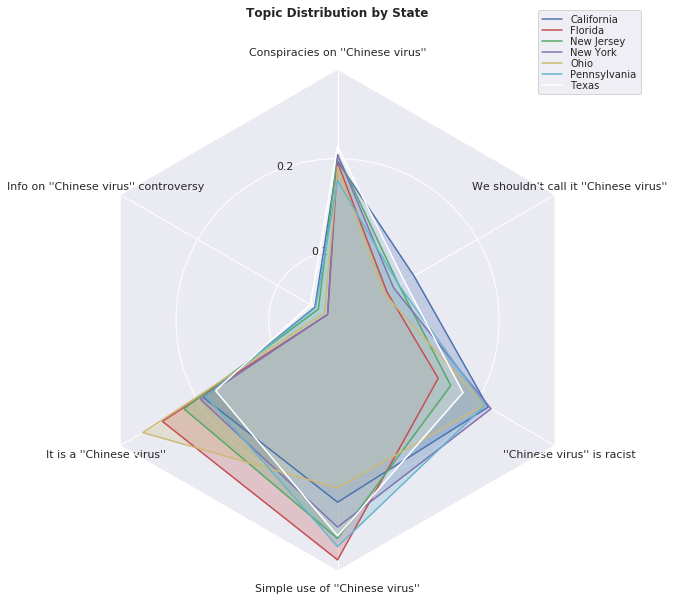

In [97]:
fig = spider_plot(
    by_state[by_state['total_tweets']>500], calc_vars=list(set(df['cluster_int'])), obs_var='admin1'
)
plt.show()

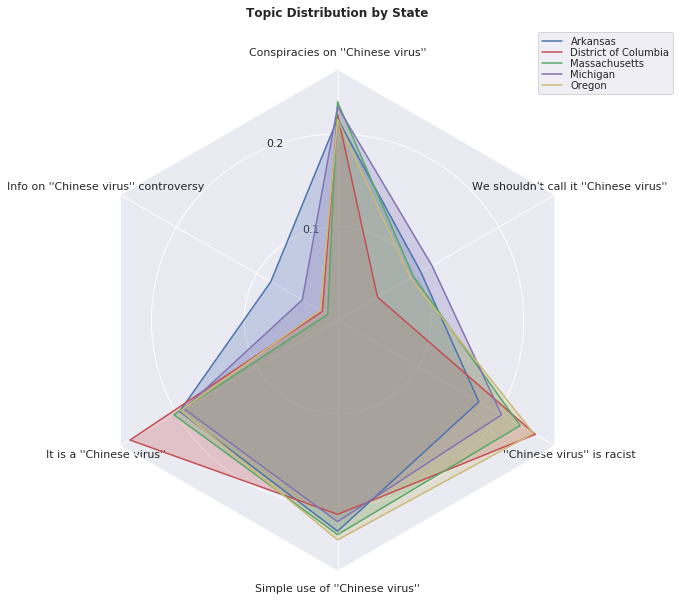

In [98]:
fig = spider_plot(by_state[by_state['admin1'].isin([
   'District of Columbia', 'Arkansas', 'Massachusetts', 'Michigan', 'Oregon'
])], calc_vars=list(set(df['cluster_int'])), obs_var='admin1')
fig.savefig('../output/chinese_virus/radar_plot.jpg', bbox_inches='tight')
plt.show()

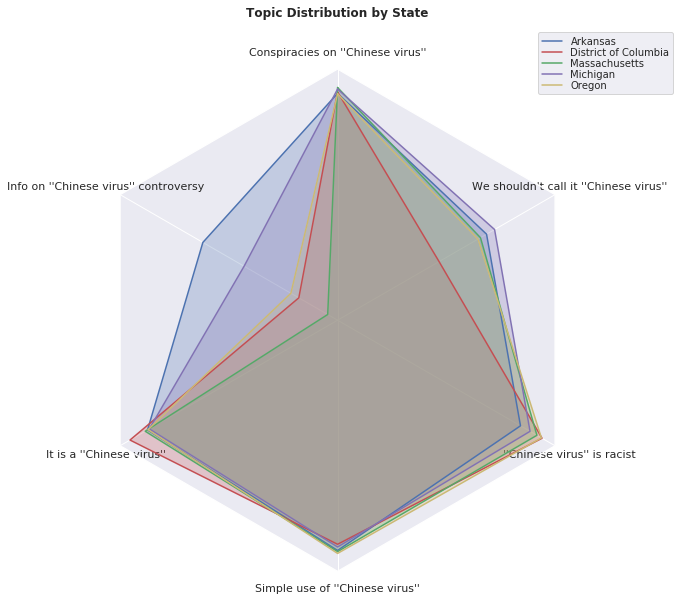

In [99]:
fig = spider_plot(by_state[by_state['admin1'].isin([
   'District of Columbia', 'Arkansas', 'Massachusetts', 'Michigan', 'Oregon'
])], calc_vars=list(set(df['cluster_int'])), obs_var='admin1', log_values=True)
fig.savefig('../output/chinese_virus/radar_plot_log.jpg', bbox_inches='tight')
plt.show()

## Investigation of Conspiracy spreaders

In [24]:
df[df['cluster_int']=='Conspiracies on ``Chinese virus\'\'']['sender_id'].value_counts().head()

714949505720823808    11
982561088620384256     8
4288324559             7
457820209              6
342289303              6
Name: sender_id, dtype: int64

Who is "714949505720823808"? https://twitter.com/DebraMMason1

```
Nationalist DebGlowing starGlowing starGlowing star
@DebraMMason1
⭐⭐ #KeepAmericaGreat ⭐⭐
#Christian Conservative #JobsNotMobs #MAGA #KAG #Israel #2A #AmericaFirst  #Brexit #NRA 
#TrumpPence2020 ⭐No Lists
```

In [25]:
df[df['sender_id']==714949505720823808]['cluster_int'].value_counts()

Conspiracies on ``Chinese virus''         11
Info on ``Chinese virus'' controversy      8
``Chinese virus'' is racist                6
We shouldn't call it ``Chinese virus''     3
Simple use of ``Chinese virus''            1
It is a ``Chinese virus''                  1
Name: cluster_int, dtype: int64

Several Tweets categorized as "Real news" (6):

In [26]:
df[(df['sender_id']==714949505720823808)&(df['cluster_int']=="Info on ``Chinese virus'' controversy")]['tweet_text'].values

array(['@Bloomberg the Chinese "model" was to let infected individuals fly around the world to spread #ChineseVirus since N… https://t.co/x734EnmB2I',
       '#ChinaLiedPeopleDied #ChineseVirus   Thank God for President Trump @realDonaldTrump !!!@',
       'Stop distrating #ChineseVirus briefings with you BS!!!!   #ChinaLiedPeopleDied',
       'President Trump calls it #ChineseVirus to counter Communist Chinese Government Propaganda! China is trying to dicta… https://t.co/PqUuFD5scn',
       'I wish Hollywood would move to China.   #HollywoodSoldOut.  #ChineseCoronaVirus  #ChinesePropaganda',
       'Its almost like Communist Chinese Government intentionally released #ChineseCoronaVirus on the world to collapse wo… https://t.co/kWSlGGQRPs',
       'Much bigger. President Trump is calling it the Chinese Virus to counter Communist Chinese Propaganda in USA and aro… https://t.co/MWivVjz9uq',
       'POTUS Trump sounded alarm on Jan 6th and was working diligently to stave off Chinese Virus

# Alternative Choice of Clusters: GMM

In [100]:
#tests gmm component possibilities with the Bayesian Information Criterion (lower is better)
lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = [
    'spherical', 'tied', 'diag', 'full'
]
for cv_type in cv_types:
    for n_components in n_components_range:
        print("Components "+str(n_components))
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type, random_state=123
        )
        gmm.fit(pca_coords)
        bic.append(gmm.bic(pca_coords))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

Components 1
Components 2
Components 3
Components 4
Components 5
Components 6
Components 7
Components 8
Components 9
Components 10
Components 11
Components 12
Components 13
Components 14
Components 15
Components 16
Components 17
Components 18
Components 19
Components 1
Components 2
Components 3
Components 4
Components 5
Components 6
Components 7
Components 8
Components 9
Components 10
Components 11
Components 12
Components 13
Components 14
Components 15
Components 16
Components 17
Components 18
Components 19
Components 1
Components 2
Components 3
Components 4
Components 5
Components 6
Components 7
Components 8
Components 9
Components 10
Components 11
Components 12
Components 13
Components 14
Components 15
Components 16
Components 17
Components 18
Components 19
Components 1
Components 2
Components 3
Components 4
Components 5
Components 6
Components 7
Components 8
Components 9
Components 10
Components 11
Components 12
Components 13


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


KeyboardInterrupt: 

In [162]:
best_gmm, lowest_bic

(GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                 means_init=None, n_components=9, n_init=1, precisions_init=None,
                 random_state=123, reg_covar=1e-06, tol=0.001, verbose=0,
                 verbose_interval=10, warm_start=False, weights_init=None),
 1301344.0932339362)

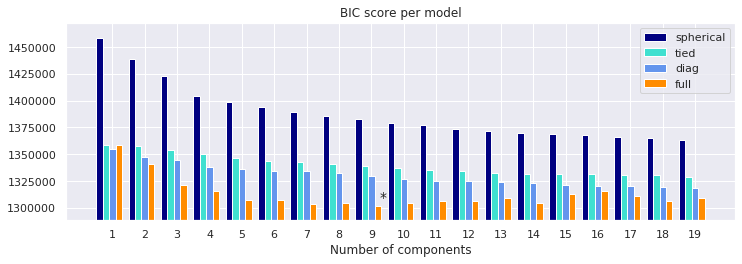

In [183]:
plot_gmm_bic(bic)
plt.show()

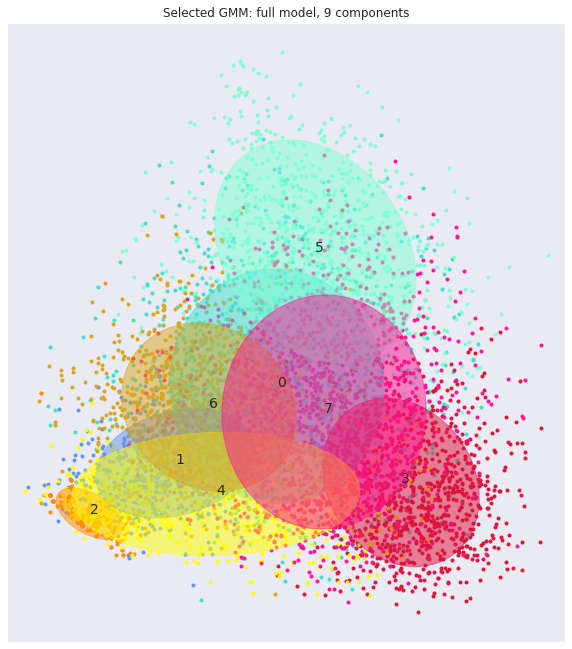

In [115]:
plot_gmm_clusters(best_gmm, pca_coords)
plt.show()

In [116]:
centers = clf.means_

i = 0
for c in centers:
    print("\n======================")
    print('For center %s' % i)
    print("Top 5 most similar sentences in corpus:")
    i += 1
    
    distances = scipy_distance.cdist([c], pca_coords, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])
    
    for idx, distance in results[0:5]:
        print(df['tweet_text_clean'].values[idx].strip(), "(Score: %.4f)" % (1-distance))


For center 0
Top 5 most similar sentences in corpus:
nancy pelosi firmly believes solar panels will cure you from the chinese virus with weekly visits at your local abo… (Score: 0.8143)
after several days of the chinese virus 🦠 quarantine! horse with no name by america, my top 5 all time favorite tun… (Score: 0.8019)
just got put on a paid leave due to #chinesevirus exposure 14 day quarantine #stayhome (Score: 0.7995)
tonight 3 of the 4 favorites won their battles to advance to saturday's #elite8 games. #1 #chinavirus will play thi… (Score: 0.7950)
chinavirus cure is for sale online! it's the malaria drug and has proven 100% cure rate in 6 days! don't be foo… (Score: 0.7878)

For center 1
Top 5 most similar sentences in corpus:
so it's called the chinese virus now? #coronavirus #covid19 (Score: 0.8091)
mfs said the chinese virus lmfao (Score: 0.8027)
lmfao i with trump on this one🤣 the chinese virus (Score: 0.7838)
potus called it the chinese virus 🦠 🤦🏾‍♂️ #covid19 (Score: 0.7788)
now

0. Fake news!
1. Chinese Virus
2. Chinese Virus
3. Racist
4. WTF (surprise, disbelief)
5. It is not a chinese virus
6. Trump support
7. Don't call it chinese virus
8. Anger, both for and against Trump

0: Fake News, conspiracy

1 & 2: Casual use of Chinese virus

3 & 8: Anger

5 & 7 & 4: This is not Chinese Virus

6: Trump support

## GMM Cluster Analysis

In [132]:
df['cluster'] = Y_
df.loc[df['cluster'].isin([0]), 'cluster_2'] = 'Conspiracy'
df.loc[df['cluster'].isin([1, 2]), 'cluster_2'] = 'Casual use of Chinese Virus'
df.loc[df['cluster'].isin([3, 8]), 'cluster_2'] = 'Anger'
df.loc[df['cluster'].isin([5, 4, 7]), 'cluster_2'] = 'Protesting the use of Chinese Virus'
df.loc[df['cluster'].isin([6]), 'cluster_2'] = 'Trump Support'

In [133]:
df['cluster'].value_counts()

8    1392
0    1389
7    1216
3    1084
6     946
5     786
1     743
4     558
2     297
Name: cluster, dtype: int64

In [134]:
df['cluster_2'].value_counts()

Protesting the use of Chinese Virus    2560
Anger                                  2476
Conspiracy                             1389
Casual use of Chinese Virus            1040
Trump Support                           946
Name: cluster_2, dtype: int64

In [123]:
center_distances = np.ones((len(centers), len(centers)))
for i in range(len(centers)):
    for j in range(len(centers)):
        if i<j:
            center_distances[i,j] = np.nan
        else:
            center_distances[i,j] = scipy_distance.cdist([centers[i]], [centers[j]], metric='cosine')[0][0]
pd.DataFrame(center_distances)

,0,1,2,3,4,5,6,7,8
0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.210810,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.323974,0.412106,2.220446e-16,NaN,NaN,NaN,NaN,NaN,NaN
3,1.431364,1.564874,1.386937e+00,0.000000,NaN,NaN,NaN,NaN,NaN
4,1.579875,0.583290,2.033844e-01,1.062018,0.000000,NaN,NaN,NaN,NaN
5,0.884431,1.360036,1.237289e+00,1.177357,1.254934,0.000000,NaN,NaN,NaN
6,0.691717,0.615200,1.015018e+00,1.573590,1.248964,1.147586,0.000000,NaN,NaN
7,1.422349,1.456281,1.094757e+00,0.597382,0.880466,0.633356,1.614934,0.0000,NaN
8,0.960265,1.113435,1.436678e+00,0.533798,1.331622,1.618776,1.095169,1.2738,0.0


## GMM Over time trends

In [138]:
by_day = pd.crosstab(df['date'], df['cluster_2']).reset_index()
by_day['total_tweets'] = by_day[list(set(df['cluster_2']))].sum(axis=1)
by_day['date'] = pd.to_datetime(by_day['date'], format='%Y%m%d')

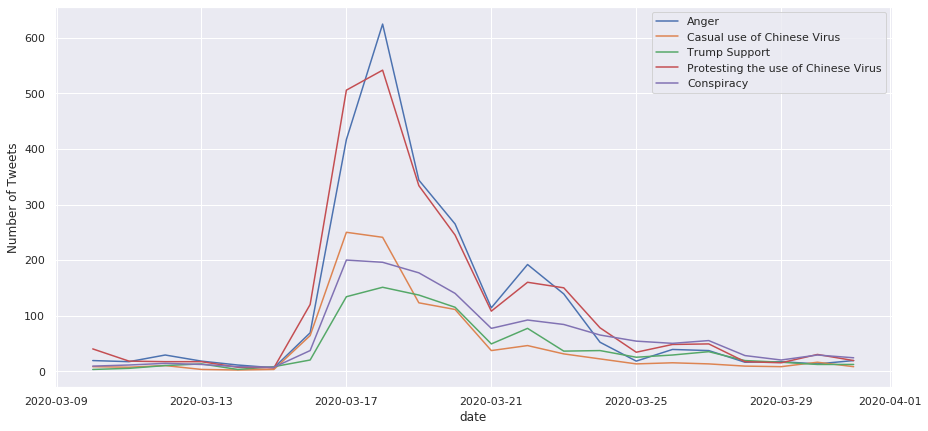

In [147]:
plt.subplots(figsize=(15,7))
for var in list(set(df['cluster_2'])):
    sns.lineplot(by_day['date'], by_day[var], label=var)
plt.legend()
plt.ylabel('Number of Tweets')
plt.show()

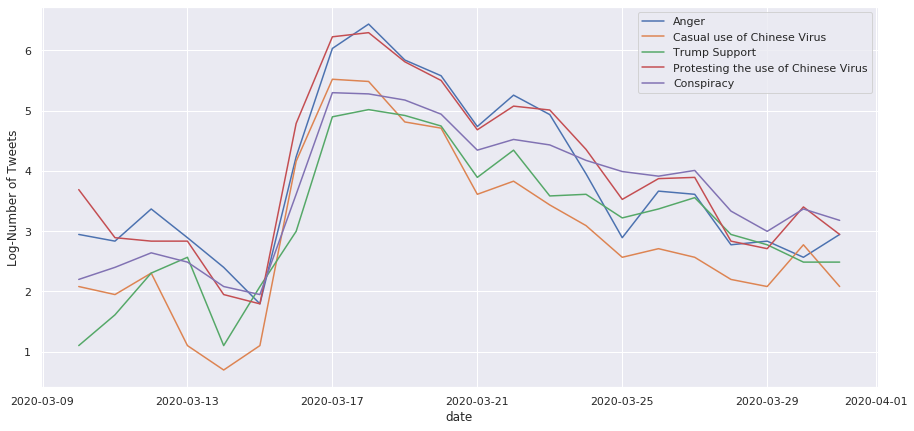

In [146]:
plt.subplots(figsize=(15,7))
for var in list(set(df['cluster_2'])):
    sns.lineplot(by_day['date'], np.log(by_day[var]), label=var)
plt.legend()
plt.ylabel('Log-Number of Tweets')
plt.show()

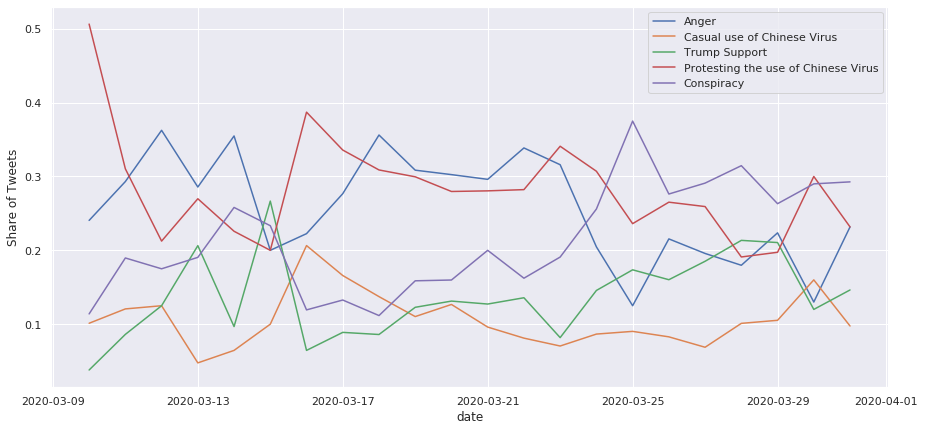

In [148]:
plt.subplots(figsize=(15,7))
for var in list(set(df['cluster_2'])):
    by_day[var] = by_day[var]/by_day['total_tweets']
    sns.lineplot(by_day['date'], by_day[var], label=var)
plt.ylabel('Share of Tweets')
plt.show()

## GMM Geography Analysis

In [150]:
by_state = pd.crosstab(df['admin1'], df['cluster_2']).reset_index()
by_state['total_tweets'] = by_state[list(set(df['cluster_2']))].sum(axis=1)
by_state = pd.merge(by_state, states.rename(columns={'state':'admin1'}), how='left', on='admin1')
for var in list(set(df['cluster_2'])):
    by_state[var] = by_state[var]/by_state['total_tweets']
by_state = by_state[by_state['population'].notnull()].reset_index(drop=True)

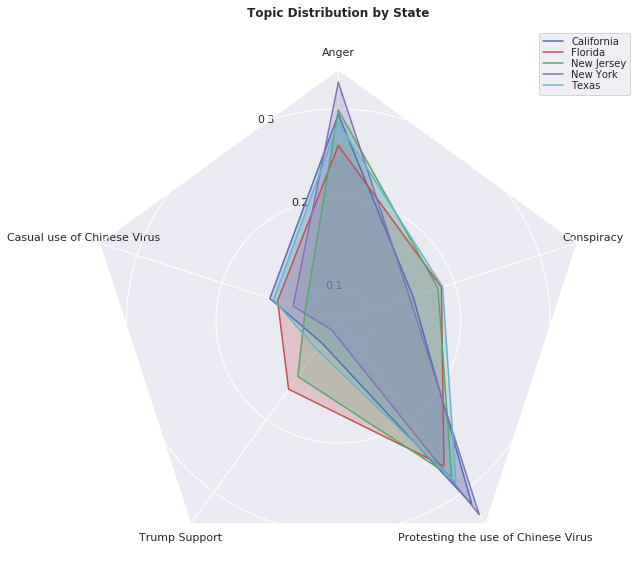

In [157]:
spider_plot(by_state[by_state['total_tweets']>300], calc_vars=list(set(df['cluster_2'])), obs_var='admin1')

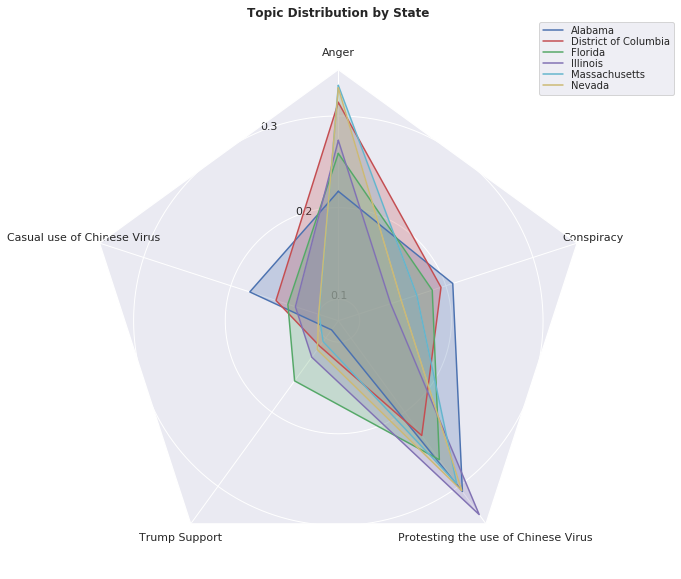

In [158]:
spider_plot(by_state[by_state['admin1'].isin([
   'District of Columbia', 'Massachusetts', 'Alabama', 'Nevada', 'Illinois', 'Florida'
])], calc_vars=list(set(df['cluster_2'])), obs_var='admin1')

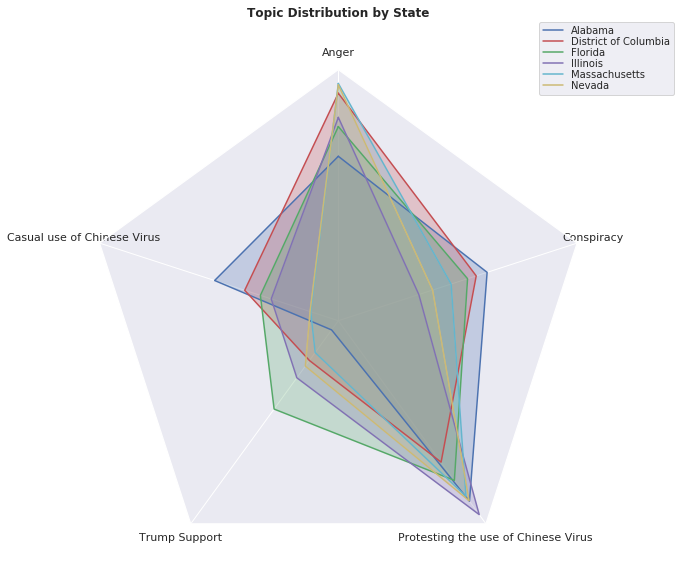

In [160]:
spider_plot(by_state[by_state['admin1'].isin([
   'District of Columbia', 'Massachusetts', 'Alabama', 'Nevada', 'Illinois', 'Florida'
])], calc_vars=list(set(df['cluster_2'])), obs_var='admin1', log_values=True)

# Sandbox